In [1]:
import sys
sys.path.insert(0, '../code/')
sys.path.insert(0, '../data/')
import lcbnn_multiclass as lcbnn
import synthetic
from utils import plot_confusion_matrix
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Input, Merge, Reshape
from keras.layers.core import Lambda, Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Settings
plt.rcParams['figure.figsize'] = (13, 13) # Width and height
np.random.seed(seed=0)
random.seed(0)
batch_size = 5
epochs = 150
evaluate = True
training = False

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Sources:

https://github.com/divamgupta/image-segmentation-keras/blob/master/Models/Segnet.py

https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/model-basic.py


## Import data

In [2]:
num_classes = 12

data_path = '../../loss-cal-BNN/Segnet/'  # This needs to change
# Data

if evaluate == False:
    x_train = np.load( data_path + 'data/train_data.npy')
    x_train = np.moveaxis(x_train,1,-1)
    y_train = np.load(data_path + 'data/train_label.npy')

    x_val = np.load(data_path + 'data/val_data.npy')
    x_val = np.moveaxis(x_val,1,-1)
    y_val = np.load(data_path + 'data/val_label.npy')

else:
    x_test = np.load(data_path + 'data/test_data.npy')
    x_test = np.moveaxis(x_test,1,-1)
    y_test = np.load(data_path + 'data/test_label.npy')


# x_train = x_train[:,1:89,:,:]
# x_test = x_test[:,1:89,:,:]
# x_val = x_val[:,1:89,:,:]

# Moveaxis for theano shape
if evaluate == False:
    x_train = np.moveaxis(x_train[:360],-1,1)
    y_train = y_train[:360]

    x_val = np.moveaxis(x_val[:100],-1,1)
    y_val = y_val[:100]

else:
    x_test = np.moveaxis(x_test[:233],-1,1)
    y_test = y_test[:233]

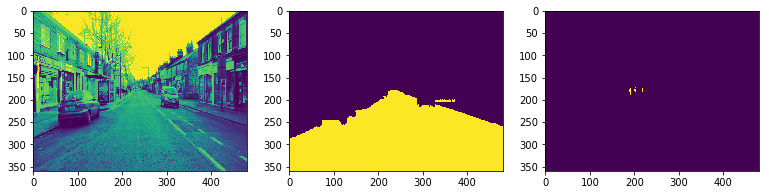

<Figure size 936x936 with 0 Axes>

In [3]:
# Some plot TODO?
if training:
    plt.rcParams['figure.figsize'] = (13, 13) # Width and height
    plt.figure()
    plt.subplot(331)
    plt.imshow(x_train[200,0,:,:])
    plt.subplot(332)
    plt.imshow(y_train.reshape((y_train.shape[0],360,480,num_classes))[200,:,:,3])
    plt.subplot(333)
    plt.imshow(y_train.reshape((y_train.shape[0],360,480,num_classes))[200,:,:,9])
    plt.show()
    plt.clf() # Save memory where possible
else:
    plt.rcParams['figure.figsize'] = (13, 13) # Width and height
    plt.figure()
    plt.subplot(331)
    plt.imshow(x_test[200,0,:,:])
    plt.subplot(332)
    plt.imshow(y_test.reshape((y_test.shape[0],360,480,num_classes))[200,:,:,3])
    plt.subplot(333)
    plt.imshow(y_test.reshape((y_test.shape[0],360,480,num_classes))[200,:,:,9])
    plt.show()
    plt.clf() # Save memory where possible

## Set up utility

In [5]:
I = np.eye(num_classes)
object_name = ['Sky', 'Building', 'Pole', 'Road', 'Pavement',
 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian','Cyclist','Unlabelled']

digits_lower_loss = [8,9,10]
sky = [0]
building = [1]

L = np.copy(I)
L[np.where(I==0)] = 0.6
L[digits_lower_loss] = 0.4 # Select more important rows with lower loss in prediction
L[sky] = 0.8
L[building] = 0.8

# Fill columns:
# L[:,digits_lower_loss] = 1.0
L[np.flip(digits_lower_loss[1:],0),digits_lower_loss[1:]] = 0

L[np.where(I==1)] = 0

loss_mat = L
M = 0.80001

print("         TRUTH\n" )
string = 'PRED'
for i in range(num_classes):
    if i < 4:
        print(string[i],'  ',object_name[i],': ',M - loss_mat[i])
    else:
        print('    ',object_name[i],': ',M - loss_mat[i])
        
# Set up weight for weighted cross entropy
# Maximise
factor = 10.

class_weight = np.ones((num_classes))
class_weight[digits_lower_loss] = (1./0.2) * factor
class_weight[sky] = (1./0.8) * factor
class_weight[building] = 1./1. * factor

         TRUTH

P    Sky :  [0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
R    Building :  [0.8 0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
E    Pole :  [0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
D    Road :  [0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
     Pavement :  [0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6]
     Tree :  [0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6]
     SignSymbol :  [0.6 0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6]
     Fence :  [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6]
     Car :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.4 0.4 0.4]
     Pedestrian :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.  0.4]
     Cyclist :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.  0.4]
     Unlabelled :  [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0. ]


In [97]:
index = [16,85,143,173,192,204]
test_images = x_test[index]
test_labels = y_test[index]

# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f for f in listdir('../../SegNet-Tutorial/CamVid/test/') if isfile(join('../../SegNet-Tutorial/CamVid/test/', f))]

png_location = '../../SegNet-Tutorial/CamVid/test'
# test_files = onlyfiles[index[0]]

data = []
label = []
with open(png_location +'.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]

In [117]:
test_files = [txt[index[i]][0][8:] for i in range(len(index))]

In [118]:
test_files

['CamVid/test/0001TP_009030.png',
 'CamVid/test/Seq05VD_f00690.png',
 'CamVid/test/Seq05VD_f02430.png',
 'CamVid/test/Seq05VD_f03330.png',
 'CamVid/test/Seq05VD_f03900.png',
 'CamVid/test/Seq05VD_f04260.png']

## General network structure

In [7]:
dropout = 0.5 # as in paper
# Regularise
# tau = 1.0
# lengthscale = .01
# reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# Legacy theano
K.set_image_dim_ordering('th')

def segnet(nClasses , optimizer=None , input_height=360, input_width=480 ):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    model = Sequential()
    model.add(Layer(input_shape=(3, input_height , input_width )))

    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added

    # decoder
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())
    
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())


    model.add(Convolution2D( nClasses , 1, 1, border_mode='valid',))

    model.outputHeight = model.output_shape[-2]
    model.outputWidth = model.output_shape[-1]


    model.add(Reshape(( nClasses ,  model.output_shape[-2]*model.output_shape[-1]   ), input_shape=( nClasses , model.output_shape[-2], model.output_shape[-1]  )))

    model.add(Permute((2, 1)))
    model.add(Activation('softmax'))

    if not optimizer is None:
        model.compile(loss="categorical_crossentropy", optimizer= optimizer , metrics=['accuracy'] )

    return model

In [7]:
# TODO Segnet without dropout (for comparison)

In [8]:
epoch10_std = '../models/segnet/segnet_std_dropout_10epoch.h5'

### Standard

In [9]:
weights_file_std = '../models/segnet/exp4_150_epoch/segnet_std_dropout_100.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

std_model = segnet(nClasses = num_classes)
std_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

std_model.load_weights(epoch10_std)
if training == True:
    history_std = std_model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=[x_val,y_val],
                      callbacks=[lr_reducer, early_stopper, model_checkpoint],
                      shuffle=True)
std_model.load_weights(weights_file_std) 

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

In [10]:
# import pickle
# pickle.dump(history_std.history,open("../models/segnet/exp4_150_epoch/history_std_56_10init_epochs.p","wb"))

### Weighted

In [11]:
weights_file_we = '../models/segnet/exp4_150_epoch/segnet_we_dropout_100.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_we, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

we_model = segnet(nClasses = num_classes)
we_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
we_model.load_weights(epoch10_std)
if training == True:
    history_we = we_model.fit(x_train, y_train,
                      class_weight = class_weight,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=[x_val,y_val],
                      callbacks=[lr_reducer, early_stopper, model_checkpoint],
                      shuffle=True)
we_model.load_weights(weights_file_we)  

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

In [12]:
# pickle.dump(history_we.history,open("../models/segnet/exp4_150_epoch/history_we_66_10init_epochs.p","wb"))

### Loss-calibrated

In [13]:
N_tr = 360
N_val = 100
height = 360
width = 480

weights_file_lc = '../models/segnet/exp4_150_epoch/segnet_lc_dropout_150.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_lc, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

M_tf = tf.constant(M, dtype=tf.float32)
basic_model = segnet(nClasses = num_classes)
# Initilise loss
loss = lcbnn.loss_K(loss_mat,Segmentation=True)

H_x = Input(shape=(height*width,num_classes),name='H_x')
y_true = Input(shape=(height*width,num_classes),name='y_true')
x = Input(shape=(3, height , width ),name='x')

# load pretrained weights
basic_model.load_weights(epoch10_std)

y_pred = basic_model(x)

lc_model = Model([x,H_x],y_pred)

# lc_model_reshape_output = Model([x,H_x],y_pred_r)

lc_model.compile(loss = lcbnn.cal_loss(loss,M,H_x,Segmentation=True),optimizer='adam')

#Initiailisations:

if evaluate==False:
    y_pred_samples = np.expand_dims(y_train,0).reshape((1,N_tr*height*width,num_classes))
    y_pred_samples_val = np.expand_dims(y_val,0).reshape((1,N_val*height*width,num_classes))

    H_x = lcbnn.optimal_h(y_pred_samples,loss_mat).reshape((N_tr,height*width,num_classes)) #np.random.randint(0,2,(np.shape(y_train)))
    H_x_val = lcbnn.optimal_h(y_pred_samples_val,loss_mat).reshape((N_val,height*width,num_classes))

    del y_pred_samples
    del y_pred_samples_val
# lc_model.load_weights(epoch10_std)
if training == True:
    history_lc = []
    for epoch in range(epochs):
        h_lc = lc_model.fit([x_train,H_x],[y_train],
                     batch_size=batch_size,
                     nb_epoch=1,
                     verbose=2,
                     validation_data=[[x_val,H_x_val],y_val],
                     callbacks=[lr_reducer, early_stopper, model_checkpoint],
                     shuffle=True)
        T = 5
        yt_hat = np.array([lc_model.predict([x_train,H_x],batch_size=batch_size) for _ in range(T)])
        yt_hat = yt_hat.reshape((T,N_tr*height*width,num_classes))
        H_x = lcbnn.optimal_h(yt_hat,loss_mat).reshape((N_tr,height*width,num_classes))
        del yt_hat
        history_lc.append(h_lc)
        if epoch % 10 ==1:
            print('Epoch: ',epoch)
        
lc_model.load_weights(weights_file_lc) 

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

## Results

In [14]:
N_te = 6

# weights_file_we = '../models/segnet/exp2_100_epoch/segnet_we_dropout_100.h5'
# we_model.load_weights(weights_file_we)

# weights_file_std = '../models/segnet/exp2_100_epoch/segnet_std_dropout_100.h5'
# std_model.load_weights(weights_file_std)

# weights_file_lc = '../models/segnet/exp2_100_epoch/segnet_lc_dropout_100.h5'
# lc_model.load_weights(weights_file_lc)

T = 10
H_x_test = np.zeros_like(test_labels)

#######
# STD #
#######
yt_hat_std = np.array([std_model.predict([test_images]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_std = np.mean(yt_hat_std, 0)
H_x_test_std, R_std = lcbnn.optimal_h(yt_hat_std,loss_mat, return_risk = True)
H_x_test_std = H_x_test_std.reshape((N_te,height*width,num_classes))
acc_std = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_std.reshape((N_te*height*width,num_classes)),1))
loss_std = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),H_x_test_std.reshape((N_te*height*width,num_classes)),loss_mat))
print('Standard:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)

# del yt_hat_std

#######
# WEI #
#######
yt_hat_we = np.array([we_model.predict([test_images]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_we = np.mean(yt_hat_we, 0)
H_x_test_we, R_we = lcbnn.optimal_h(yt_hat_we,loss_mat, return_risk = True)
H_x_test_we = H_x_test_we.reshape((N_te,height*width,num_classes))
acc_we = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_we.reshape((N_te*height*width,num_classes)),1))
loss_we = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),H_x_test_we.reshape((N_te*height*width,num_classes)),loss_mat))

print('\nWeighted:\n')
print('Accuracy on optimal decision: ', acc_we)
print('Expected loss: ', loss_we)

# del yt_hat_we

#######
# L-C #
#######
yt_hat_lc = np.array([lc_model.predict([test_images, H_x_test]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_lc = np.mean(yt_hat_lc, 0)
H_x_test_lc, R_lc = lcbnn.optimal_h(yt_hat_lc,loss_mat, return_risk = True)
H_x_test_lc = H_x_test_lc.reshape((N_te,height*width,num_classes))
acc_lc = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_lc.reshape((N_te*height*width,num_classes)),1))
loss_lc = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),H_x_test_lc.reshape((N_te*height*width,num_classes)),loss_mat))
print('\nLoss-cal:\n')
print('Accuracy on optimal decision: ', acc_lc)
print('Expected loss: ', loss_lc)

# del yt_hat_lc

Standard:

Accuracy on optimal decision:  0.8073360339506173
Expected loss:  0.11117804783950613

Weighted:

Accuracy on optimal decision:  0.8286467978395061
Expected loss:  0.1020569058641975

Loss-cal:

Accuracy on optimal decision:  0.8465316358024692
Expected loss:  0.0995179398148149


In [15]:
N_te = 6

# weights_file_we = '../models/segnet/exp2_100_epoch/segnet_we_dropout_100.h5'
# we_model.load_weights(weights_file_we)

# weights_file_std = '../models/segnet/exp2_100_epoch/segnet_std_dropout_100.h5'
# std_model.load_weights(weights_file_std)

# weights_file_lc = '../models/segnet/exp2_100_epoch/segnet_lc_dropout_100.h5'
# lc_model.load_weights(weights_file_lc)

T = 10
H_x_test = np.zeros_like(test_labels)

#######
# STD #
#######
MC_pred_std = np.mean(yt_hat_std, 0)
acc_o_std = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_std.reshape((N_te*height*width,num_classes)),1))
loss_o_std = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),MC_pred_std.reshape((N_te*height*width,num_classes)),loss_mat))
print('Standard:\n')
print('Accuracy on NN output: ', acc_o_std)
print('Expected loss on NN output: ', loss_o_std)

# del yt_hat_std

#######
# WEI #
#######
MC_pred_we = np.mean(yt_hat_we, 0)
acc_o_we = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_we.reshape((N_te*height*width,num_classes)),1))
loss_o_we = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),MC_pred_we.reshape((N_te*height*width,num_classes)),loss_mat))
print('\nWeighted:\n')
print('Accuracy on NN output: ', acc_o_we)
print('Expected loss on NN output: ', loss_o_we)

# del yt_hat_we

#######
# L-C #
#######
MC_pred_lc = np.mean(yt_hat_lc, 0)
acc_o_lc = accuracy_score(np.argmax(test_labels.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_lc.reshape((N_te*height*width,num_classes)),1))
loss_o_lc = np.mean(lcbnn.loss_np(test_labels.reshape((N_te*height*width,num_classes)),MC_pred_lc.reshape((N_te*height*width,num_classes)),loss_mat))
print('\nLoss-cal:\n')
print('Accuracy on NN output: ', acc_o_lc)
print('Expected loss on NN output: ', loss_o_lc)

# del yt_hat_lc

Standard:

Accuracy on NN output:  0.834410686728395
Expected loss on NN output:  0.1621552017412397

Weighted:

Accuracy on NN output:  0.8470727237654321
Expected loss on NN output:  0.14763821590077564

Loss-cal:

Accuracy on NN output:  0.8496875
Expected loss on NN output:  0.1295203219260789


# Visualise

In [138]:
from skimage.exposure import equalize_hist
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True, one_hot=True):
    if one_hot:
        temp = np.argmax(temp,-1)
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,12):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb,aspect="auto")
        plt.xticks([])
        plt.yticks([])
    else:
        return rgb
    
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=equalize_hist(b)
    norm[:,:,1]=equalize_hist(g)
    norm[:,:,2]=equalize_hist(r)

    return norm

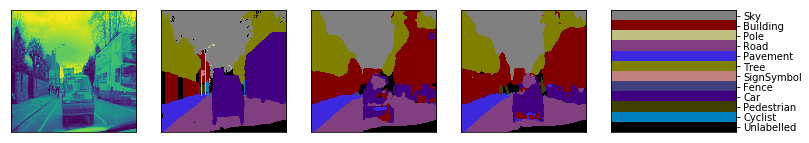

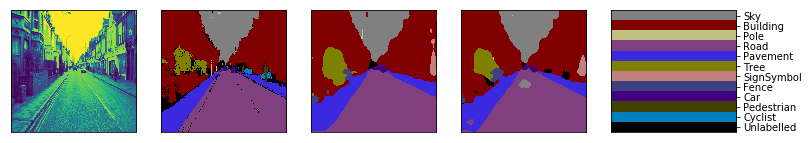

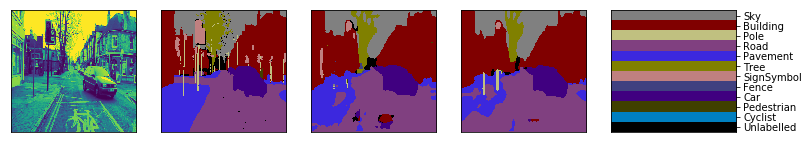

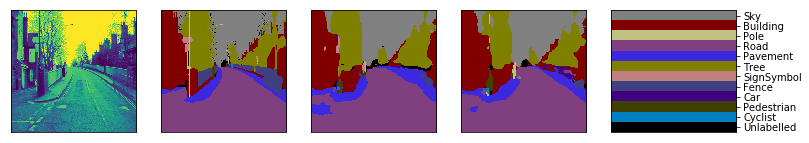

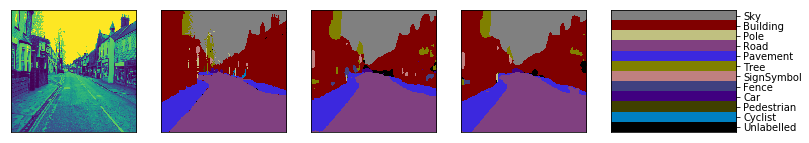

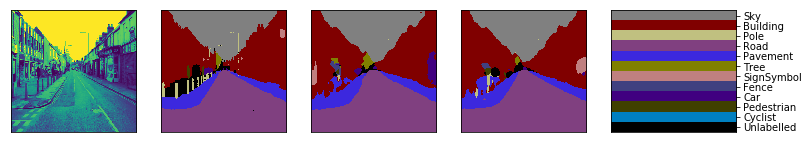

In [18]:
for n in range(N_te):
    plt.figure()
    plt.subplot(551)
    plt.imshow(test_images[n,2,:,:],aspect="auto")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(552)
    visualize(test_labels.reshape((6,360,480,num_classes))[n,:,:,:])
    plt.subplot(553)
    visualize(MC_pred_std.reshape((6,360,480,num_classes))[n,:,:,:])
    plt.subplot(554)
    visualize(MC_pred_lc.reshape((6,360,480,num_classes))[n,:,:,:])
    ax = plt.subplot(555)
    visualize(np.tile(np.arange(12),10).reshape(10,12).T,one_hot=False)
    tick_marks = np.arange(len(object_name))
    plt.yticks(tick_marks, object_name)
    ax.yaxis.tick_right()
    plt.show()

## Plot Gain maps

In [18]:
R_std_mesh = R_std.reshape((N_te,360,480,num_classes))
R_we_mesh = R_we.reshape((N_te,360,480,num_classes))
R_lc_mesh = R_lc.reshape((N_te,360,480,num_classes))

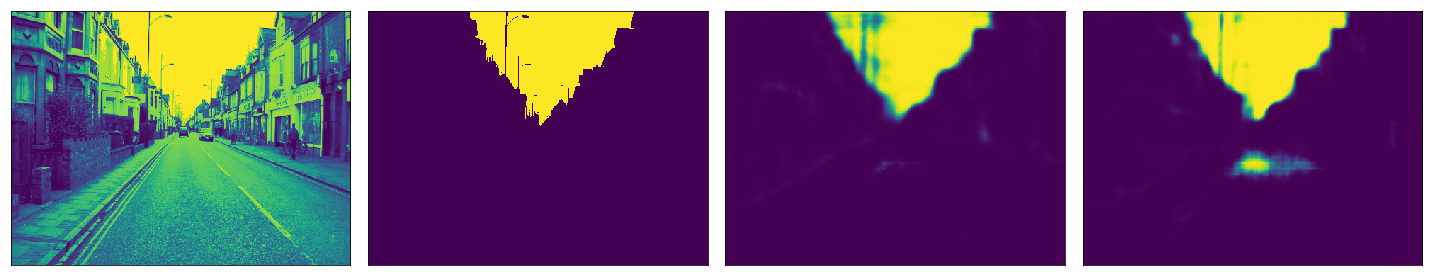

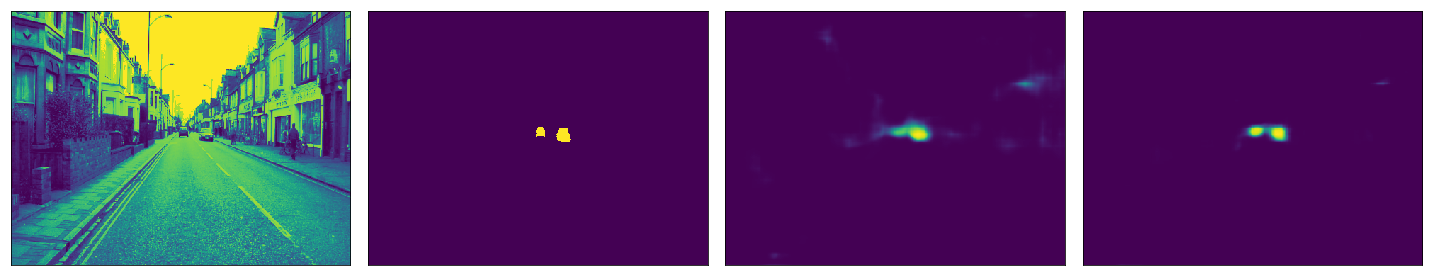

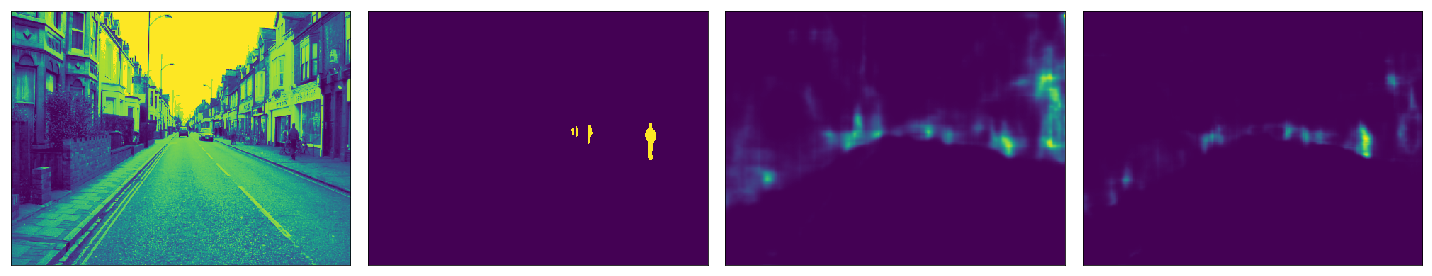

In [141]:
i = 1

plt.rcParams['figure.figsize'] = (20, 20)
plt.figure()
plt.subplot(441)
plt.imshow(test_images[i,2,:,:])
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,:,:,0])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.imshow(-R_std_mesh[i,:,:,0])
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.imshow(-R_lc_mesh[i,:,:,0])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(441)
plt.imshow(test_images[i,2,:,:])
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,:,:,8])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.imshow(-R_std_mesh[i,:,:,8])
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.imshow(-R_lc_mesh[i,:,:,8])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(441)
plt.imshow(test_images[i,2,:,:])
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,:,:,9])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.imshow(-R_std_mesh[i,:,:,9])
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.imshow(-R_lc_mesh[i,:,:,9])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

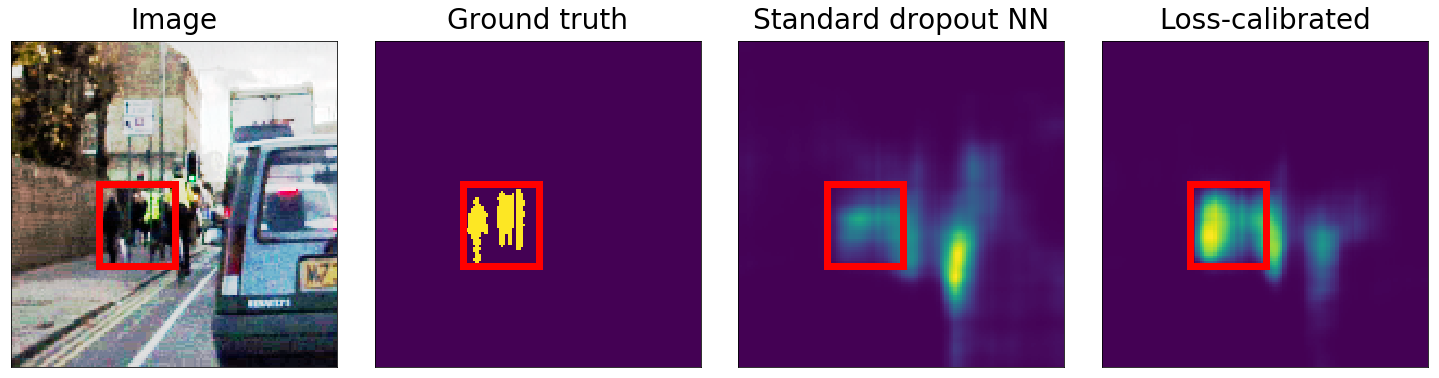

In [140]:
import matplotlib.patches as patches
if i == 0:
    rect1 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
    
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[150:300,100:250]))
#     plt.imshow(test_images[i,2,150:300,100:250])
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,150:300,100:250,9])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(-R_std_mesh[i,150:300,100:250,9])
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(-R_lc_mesh[i,150:300,100:250,9])
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/gain_ped_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()
if i == 1:
    rect1 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(im[100:250,330:])
#     plt.imshow(test_images[i,2,100:250,330:])
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,330:,9])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(-R_std_mesh[i,100:250,330:,9])
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(-R_lc_mesh[i,100:250,330:,9])
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/gain_ped_1.pdf",bbox_inches='tight',rasterized=True)
    plt.show()



### Car for image 1

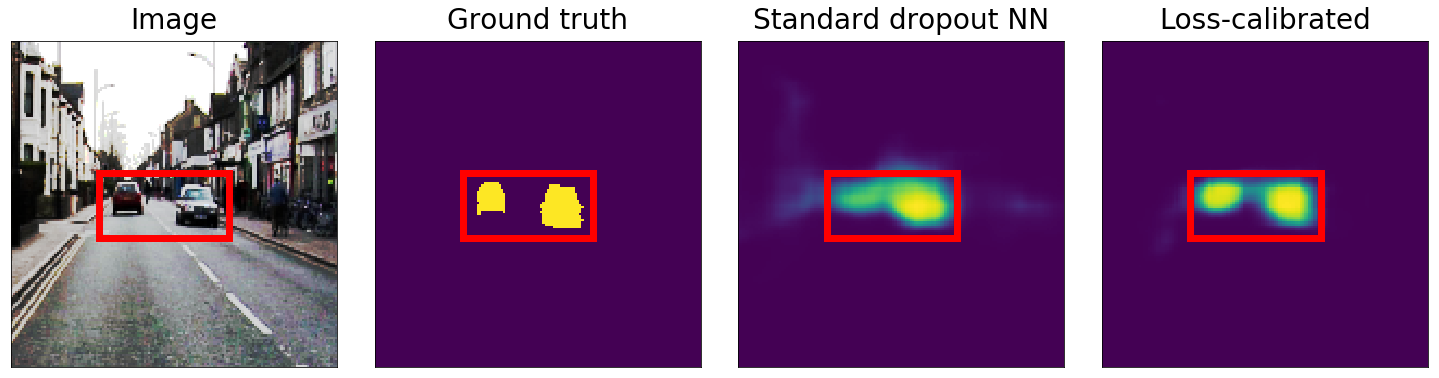

In [142]:
if i == 1:
    rect1 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[100:250,190:340]))
#     plt.imshow(test_images[i,2,100:250,190:340])
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,190:340,8])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(-R_std_mesh[i,100:250,190:340,8])
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(-R_lc_mesh[i,100:250,190:340,8])
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig("../models/segnet/exp4_150_epoch/plots/gain_car_1_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()


## Basic Class Standard Deviation

In [76]:
sig_std = yt_hat_std.std(0).reshape((N_te,360,480,num_classes))
sig_we = yt_hat_we.std(0).reshape((N_te,360,480,num_classes))
sig_lc = yt_hat_lc.std(0).reshape((N_te,360,480,num_classes))

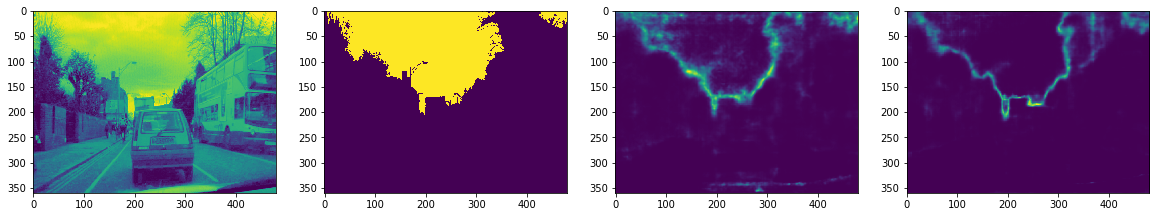

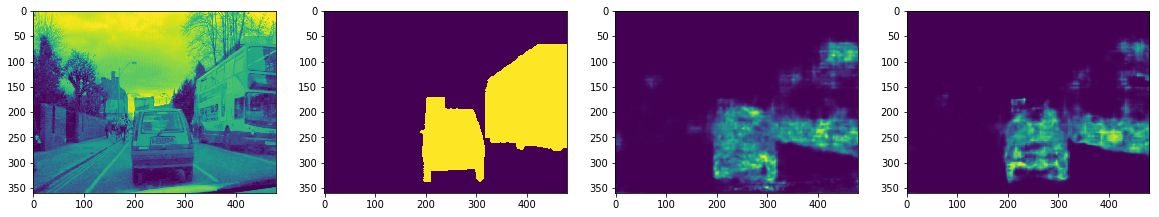

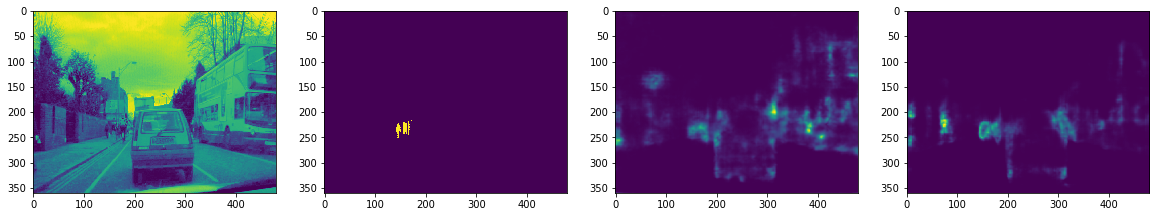

In [71]:
plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,0])
plt.subplot(443)
plt.imshow(sig_std[0,:,:,0])
plt.subplot(444)
plt.imshow(sig_lc[0,:,:,0])

plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,8])
plt.subplot(443)
plt.imshow(sig_std[0,:,:,8])
plt.subplot(444)
plt.imshow(sig_lc[0,:,:,8])

plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,9])
plt.subplot(443)
plt.imshow(sig_std[0,:,:,9])
plt.subplot(444)
plt.imshow(sig_lc[0,:,:,9])

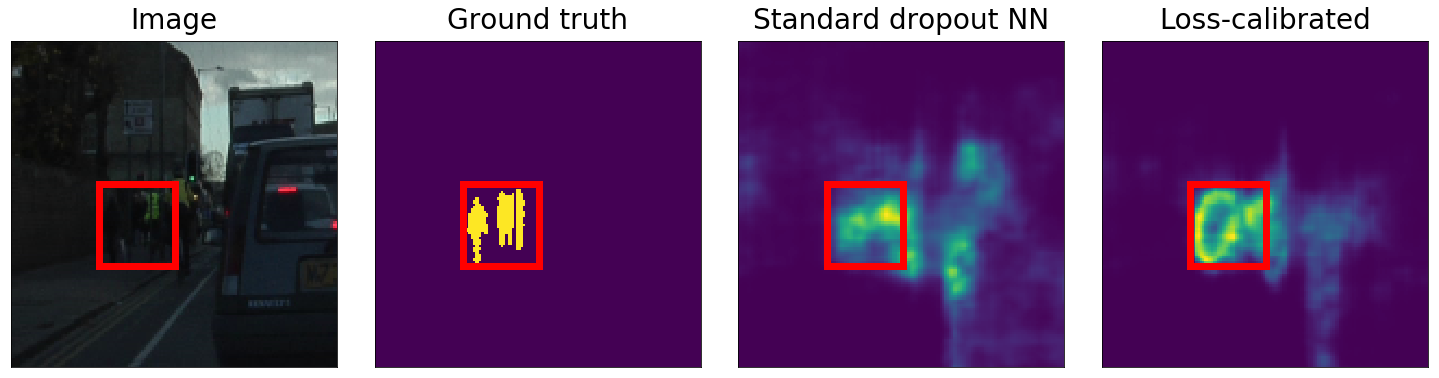

In [121]:
import matplotlib.patches as patches
import matplotlib.image as mping
rect1 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

plt.figure()
ax = plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
# plt.imshow(test_images[0,2,150:300,100:250])
im = mping.imread('../../SegNet-Tutorial/' + test_files[0])
plt.imshow(im[150:300,100:250])
ax.add_patch(rect1)
plt.xticks([])
plt.yticks([])
ax2 = plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,150:300,100:250,9])
ax2.add_patch(rect2)
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(sig_std[0,150:300,100:250,9])
ax3.add_patch(rect3)
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(sig_lc[0,150:300,100:250,9])
ax4.add_patch(rect4)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("../models/segnet/exp4_150_epoch/plots/mean_std_ped.pdf",bbox_inches='tight',rasterized=True)
plt.show()



## Mutual Information (BALD) [P. 55 Gal Thesis]

'Test points $\mathbf{x}$ that maximise the mutual information are points on which the model is uncertain on average, yet there exist model parameters that erroneously produce predictions with high confidence' 

## BALD code from:
https://github.com/yaringal/acquisition_example/blob/master/acquisition_example.ipynb 

In [144]:
def BALD_2(MC_samples):
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy
    return BALD_acq
# print('BALD_acq on first 10 points', BALD_acq[:10])

In [145]:
I_std = BALD_2(yt_hat_std).reshape((6,360,480))
I_lc = BALD_2(yt_hat_lc).reshape((6,360,480))

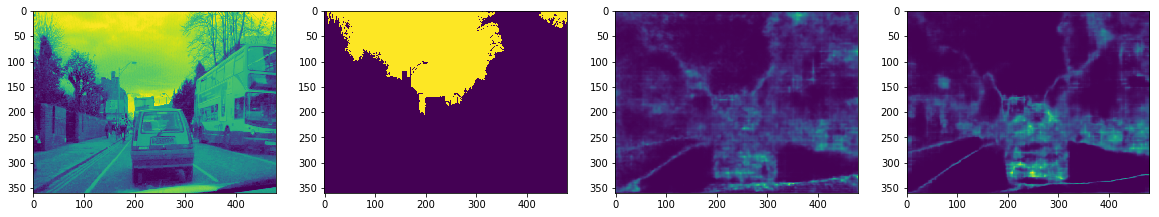

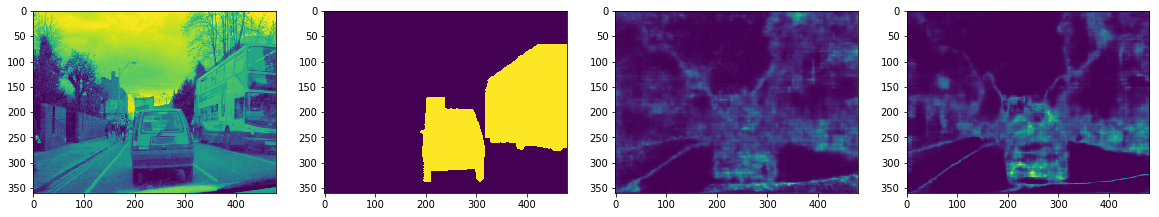

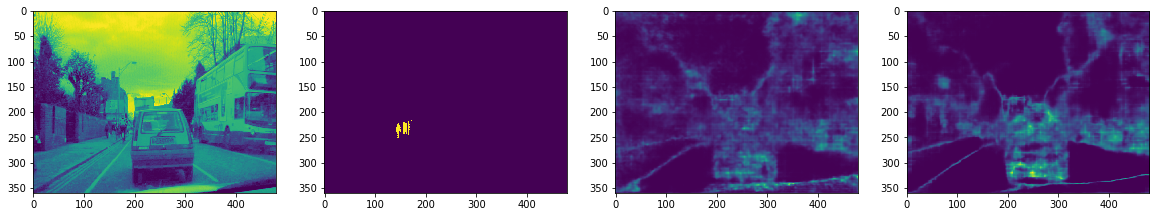

In [148]:
plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,0])
plt.subplot(443)
plt.imshow(I_std[0])
plt.subplot(444)
plt.imshow(I_lc[0])

plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,8])
plt.subplot(443)
plt.imshow(I_std[0])
plt.subplot(444)
plt.imshow(I_lc[0])

plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,9])
plt.subplot(443)
plt.imshow(I_std[0])
plt.subplot(444)
plt.imshow(I_lc[0])



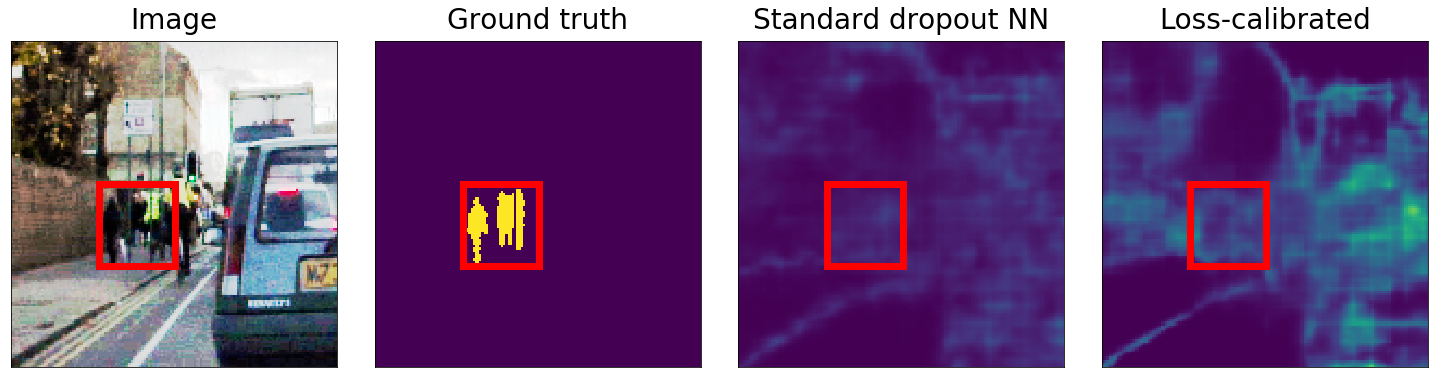

In [215]:
rect1 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
i = 0
# colour map:
combined_data = np.array([I_std[i],I_lc[i]])
_min, _max = np.min(combined_data), np.max(combined_data)

plt.figure()
ax = plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
plt.imshow(normalized(im[150:300,100:250]))
# plt.imshow(test_images[0,2,150:300,100:250])
ax.add_patch(rect1)
plt.xticks([])
plt.yticks([])
ax2 = plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,150:300,100:250,9])
ax2.add_patch(rect2)
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[0,150:300,100:250],vmin=_min,vmax=_max)
ax3.add_patch(rect3)
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[0,150:300,100:250],vmin=_min,vmax=_max)
ax4.add_patch(rect4)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("../models/segnet/exp4_150_epoch/plots/BALD_ped.pdf",bbox_inches='tight',rasterized=True)
plt.show()

In [214]:
I_lc[i].mean()
# I_std[i].mean()

0.04618245

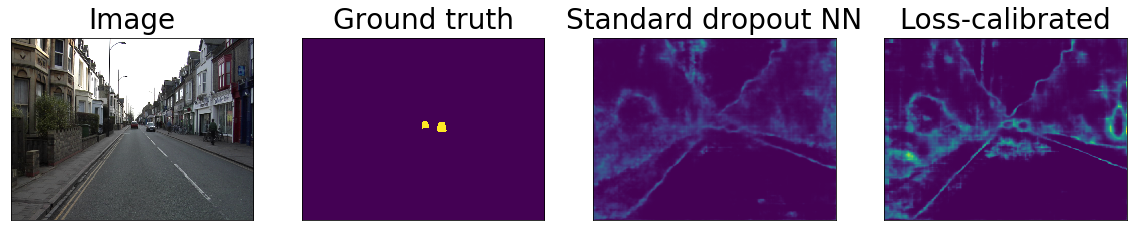

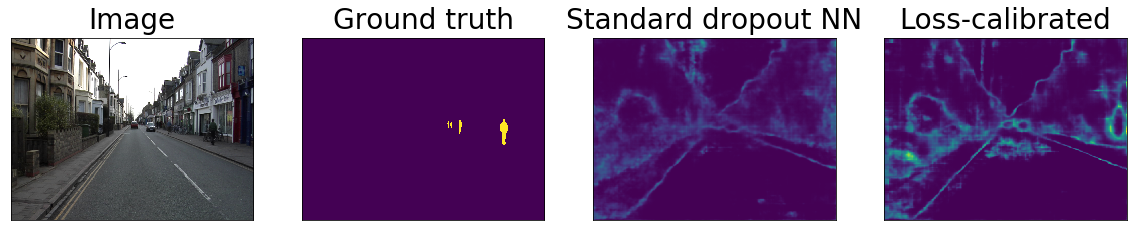

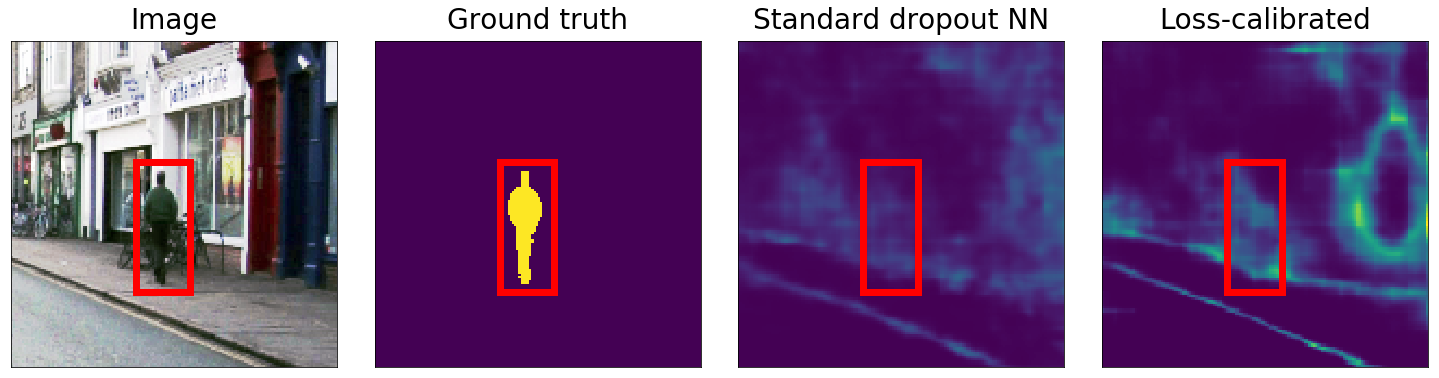

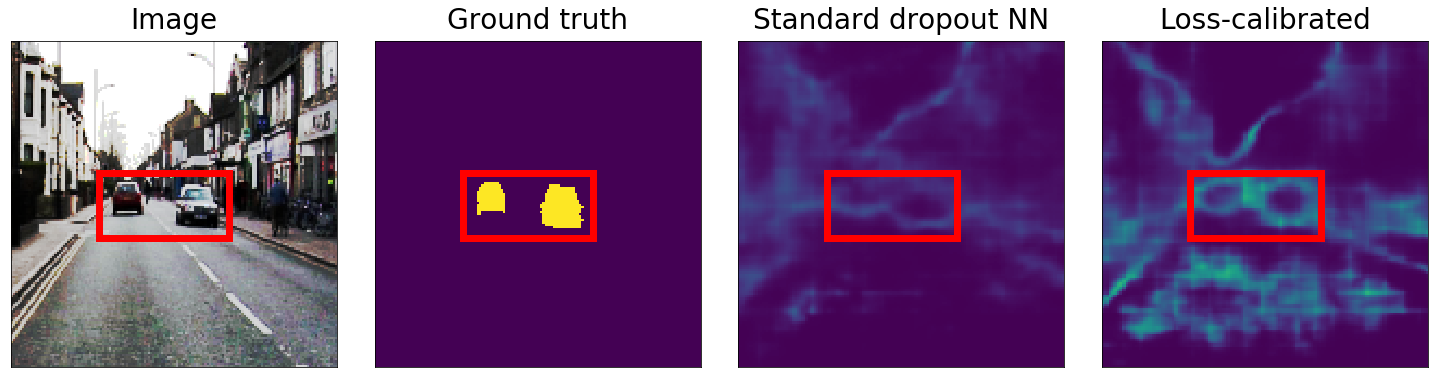

In [200]:
i = 1
# colour map:
combined_data = np.array([I_std[i],I_lc[i]])
_min, _max = np.min(combined_data), np.max(combined_data)


plt.figure()
plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
# plt.imshow(test_images[1,2,:,:])
im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[1,:,:,8])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[1],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[1],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
# plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_ped_1_zoomed_out.pdf",bbox_inches='tight',rasterized=True)



plt.figure()
plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
# plt.imshow(test_images[1,2,:,:])
im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[1,:,:,9])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[1],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[1],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
# plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_car_1_zoomed_out.pdf",bbox_inches='tight',rasterized=True)



if i == 1:
    rect1 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((57,55),25,60,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
#     plt.imshow(test_images[i,2,100:250,330:])
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[100:250,330:]))
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,330:,9])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(I_std[i,100:250,330:],vmin=_min,vmax=_max)
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(I_lc[i,100:250,330:],vmin=_min,vmax=_max)
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_ped_1_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()
    
    rect1 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((40,60),60,30,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
#     plt.imshow(test_images[i,2,100:250,190:340])
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[100:250,190:340]))
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,190:340,8])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(I_std[i,100:250,190:340],vmin=_min,vmax=_max)
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(I_lc[i,100:250,190:340],vmin=_min,vmax=_max)
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_car_1_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()


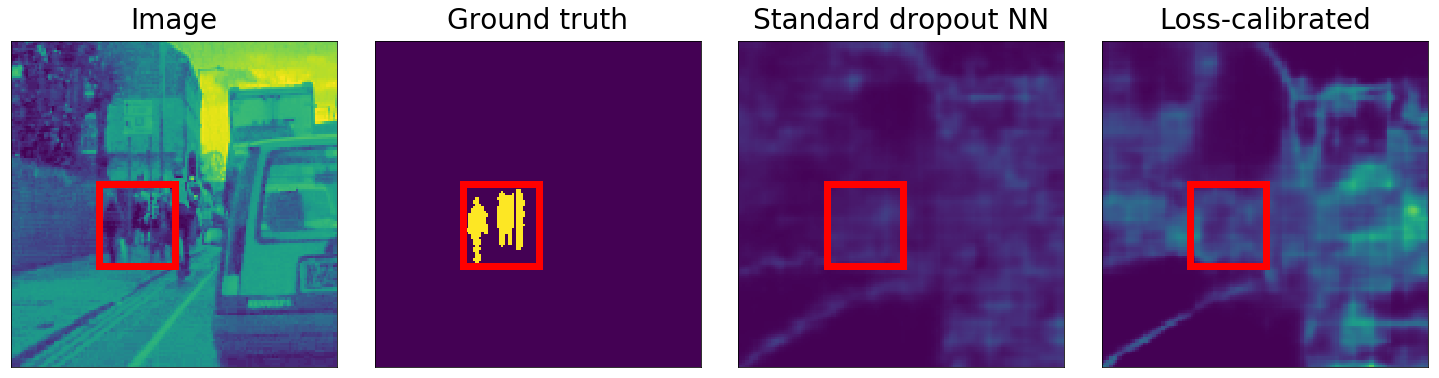

In [199]:
rect1 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((40,65),35,38,linewidth=7,edgecolor='r',facecolor='none')

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
i=0

# colour map:
combined_data = np.array([I_std[i],I_lc[i]])
_min, _max = np.min(combined_data), np.max(combined_data)

plt.figure()
ax = plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
plt.imshow(test_images[0,2,150:300,100:250])
ax.add_patch(rect1)
plt.xticks([])
plt.yticks([])
ax2 = plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,150:300,100:250,9])
ax2.add_patch(rect2)
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[0,150:300,100:250],vmin=_min,vmax=_max)
ax3.add_patch(rect3)
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[0,150:300,100:250],vmin=_min,vmax=_max)
ax4.add_patch(rect4)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("../models/segnet/exp4_150_epoch/plots/BALD_ped.pdf",bbox_inches='tight',rasterized=True)
plt.show()

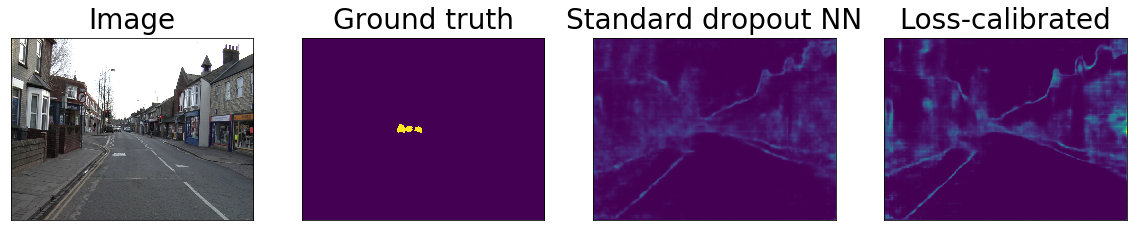

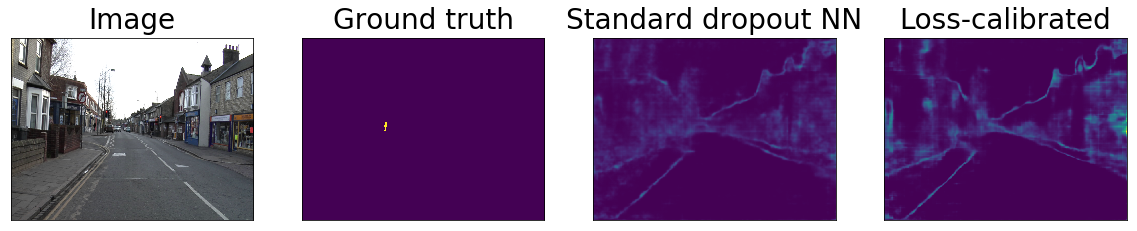

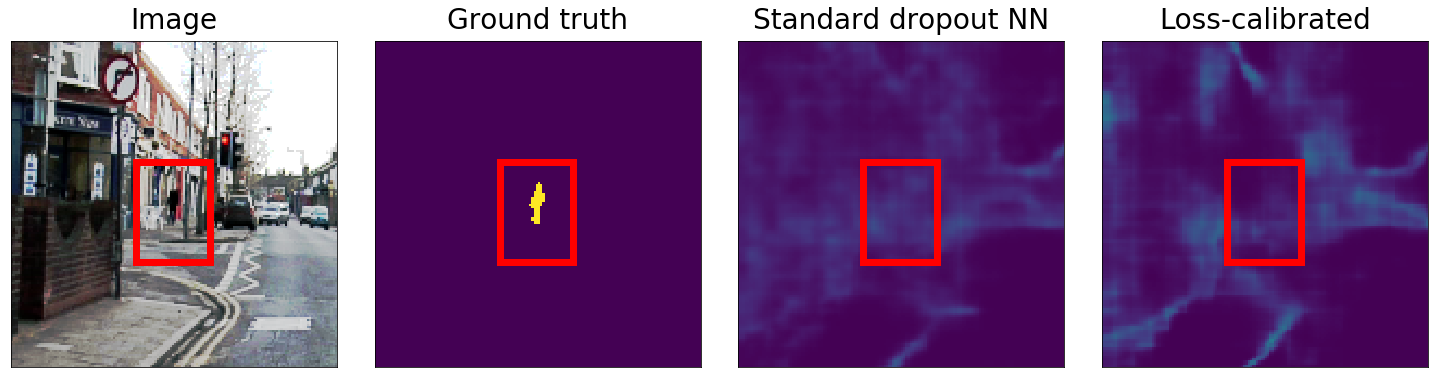

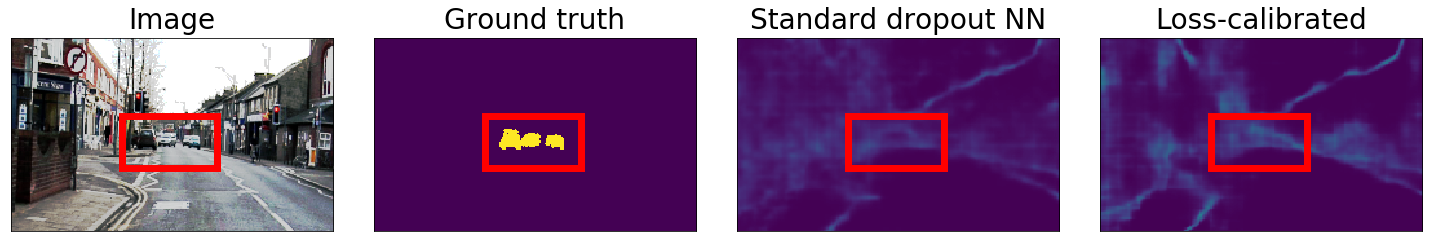

In [193]:
i=4

# colour map:
combined_data = np.array([I_std[i],I_lc[i]])
_min, _max = np.min(combined_data), np.max(combined_data)


plt.figure()
plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
# plt.imshow(test_images[1,2,:,:])
im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,:,:,8])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[i],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[i],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
# plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_ped_4_zoomed_out.pdf",bbox_inches='tight',rasterized=True)



plt.figure()
plt.subplot(441)
plt.title('Image',fontsize=28, y=1.02)
# plt.imshow(test_images[1,2,:,:])
im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.subplot(442)
plt.title('Ground truth',fontsize=28, y=1.02)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,:,:,9])
plt.xticks([])
plt.yticks([])
plt.subplot(443)
plt.title('Standard dropout NN',fontsize=28, y=1.02)
plt.imshow(I_std[i],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.title('Loss-calibrated',fontsize=28, y=1.02)
plt.imshow(I_lc[i],vmin=_min,vmax=_max)
plt.xticks([])
plt.yticks([])
# plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_car_4_zoomed_out.pdf",bbox_inches='tight',rasterized=True)



if i == 4:
    rect1 = patches.Rectangle((57,55),34,46,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((57,55),34,46,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((57,55),34,46,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((57,55),34,46,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
#     plt.imshow(test_images[i,2,100:250,330:])
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[100:250,90:240]))
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,90:240,9])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(I_std[i,100:250,90:240],vmin=_min,vmax=_max)
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(I_lc[i,100:250,90:240],vmin=_min,vmax=_max)
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_ped_4_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()
    
    rect1 = patches.Rectangle((86,60),74,40,linewidth=7,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((86,60),74,40,linewidth=7,edgecolor='r',facecolor='none')
    rect3 = patches.Rectangle((86,60),74,40,linewidth=7,edgecolor='r',facecolor='none')
    rect4 = patches.Rectangle((86,60),74,40,linewidth=7,edgecolor='r',facecolor='none')
    plt.figure()
    ax = plt.subplot(441)
    plt.title('Image',fontsize=28, y=1.02)
#     plt.imshow(test_images[i,2,100:250,190:340])
    im = mping.imread('../../SegNet-Tutorial/' + test_files[i])
    plt.imshow(normalized(im[100:250,90:340]))
    ax.add_patch(rect1)
    plt.xticks([])
    plt.yticks([])
    ax2 = plt.subplot(442)
    plt.title('Ground truth',fontsize=28, y=1.02)
    plt.imshow(test_labels.reshape((6,360,480,num_classes))[i,100:250,90:340,8])
    ax2.add_patch(rect2)
    plt.xticks([])
    plt.yticks([])
    ax3 = plt.subplot(443)
    plt.title('Standard dropout NN',fontsize=28, y=1.02)
    plt.imshow(I_std[i,100:250,90:340],vmin=_min,vmax=_max)
    ax3.add_patch(rect3)
    plt.xticks([])
    plt.yticks([])
    ax4 = plt.subplot(444)
    plt.title('Loss-calibrated',fontsize=28, y=1.02)
    plt.imshow(I_lc[i,100:250,90:340],vmin=_min,vmax=_max)
    ax4.add_patch(rect4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
#     plt.savefig("../models/segnet/exp4_150_epoch/plots/bald_car_4_norm.pdf",bbox_inches='tight',rasterized=True)
    plt.show()
